In [23]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
t1 = time.time()

In [213]:
scipy.stats.expon(5)

In [24]:
# (np.random.geometric([1,1/6],(1000,2))-1).mean(0)

## Simulation


In [336]:
# @numba.njit
def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    flux = calc_flux( population, *args)[0]
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    return rxn, t

def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1


In [337]:
# @numba.njit
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''

    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt
# def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
#                        DELAYED_SPECIES_GENERATORS, export_arr,burst_events, tau_list=None,\
#                        return_full=False,*args):

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,burst_events, burst_size_time_dep, tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1
        
    niter = 0

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)
    
#     print(burst_events)
#     print(update)
#     raise ValueError

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        t = temp_t
        if event in burst_events:
#             UPD = np.random.geometric(1/(1+update[event, :]))-1
            UPD = np.copy(update[event,:])
            bs_instantaneous = burst_size_time_dep(t)
            UPD[UPD>0] = np.random.geometric(1/(1+bs_instantaneous))-1
#             if niter<10:
#                 print('----')
#                 print(update[event,:])
#                 print(UPD)
#                 print(bs_instantaneous)
#                 niter +=1 
#             else:
#                 raise ValueError
        else:
            UPD = update[event, :]
        population = population + UPD
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr


In [338]:
def nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):
# def nondelay_wrapper(N,n,K_val,A_val,b_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):
#     print(beta_val)
    H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)
#     H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,b_val,beta_val,gamma_val)
# 
    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

#     print(S)
#     print(H)
#     print(A)
#     print(C)
#     print(k)
#     print(Hss)
#     print(burst_events)
    
    t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells)):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,burst_events,burst_size_time_dep,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob,burst_events


In [339]:
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
#     print(beta_val)
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    burst_events = []
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    
#     for av,bv_ in zip(A_val,b_val):
#         if bv_ > 0:
#             burst_events += [i]
#             S_mark[i,av[1]+N-1] = bv_
#         else:
#             S_mark[i,av[1]+N-1] = 1
#         k_mark[i] = av[2]
#         i+=1

    for av in A_val:
        #note we assume there is just the one burst event! 
        burst_events += [i]
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss,burst_events
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T


In [340]:
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g

def compute_coeff(L,V,Vinv,u,j=0):
    n_u = u.shape[1]
    a = np.asarray([(V@np.diag( Vinv @ u[:,i]))[j] for i in range(n_u)]).T
    return a

def compute_eigs(C):
    L,V = np.linalg.eig(C)
    Vinv = np.linalg.inv(V)
    return L,V,Vinv


In [428]:
def pss_wrapper(H,A,C,burst_size_time_dep,t,mx,n,N,initcond):
    g = np.asarray(get_g(mx)).T
    L,V,Vinv = compute_eigs(C)
    coeff = np.asarray([compute_coeff(L,V,Vinv,g.T,i) for i in range(n)])
    
    if initcond[0][0]=='thermalized':
        Hfin = scipy.linalg.null_space(H.T)
        Hfin /= Hfin.sum()
        w = Hfin.squeeze()
    elif initcond[0][0]=='deterministic':
        w = np.zeros(N)
        w[initcond[0][1]] = 1
    elif initcond[0][0]=='categorical':
        w = initcond[0][1]
    else:
        raise ValueError('Not implemented')
    w = np.asarray(w,dtype=np.complex128)

    gf_initcond_prop = np.ones((g.shape[0],N),dtype=np.complex128)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            for i in range(g.shape[0]):
                gf_initcond_prop[i,:] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        elif len(condition)==N: #list of length N
            for k in range(N):
                if condition[k][0]=='deterministic':
                    initcond_gfun = lambda x: (x+1)**condition[k][1]
                elif condition[k][0]=='poisson':
                    initcond_gfun = lambda x: np.exp(condition[k][1]*x)
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,k] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf_initcond_prop *= w 
    gf = gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond_prop,burst_size_time_dep)

    Pss = np.zeros((max(mx),N))
    for j in range(N):
        Pss[:,j] = np.real(ifft(gf[:,j]))
    Pss = Pss.squeeze()
    if N==1:
        Pss = Pss[:,None]
    return Pss

def gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond,burst_size_time_dep):
    gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = np.log(gf_initcond[i])
        
        Ufun = lambda x: np.asarray([ufun_generic(x,L,coef[:,i]) for coef in coeff])
        tfin = np.copy(t)
        intfun = lambda t,y: intfun_multi(t,tfin,y,H,A,Ufun,burst_size_time_dep)
        res = scipy.integrate.solve_ivp(intfun,[t0,tfin],y0,max_step = 0.05)
#         res = scipy.integrate.solve_ivp(intfun,[t,t0],y0,max_step = 0.1)
        
        while res.status == 'running':
            res.step()
        gf_[i] = res.y[:,-1]
    return np.exp(gf_)
#     return gf_

def ufun_generic(x,L,coeff):
    Ufun = (np.exp(L*x)@coeff)
    return Ufun

def intfun_multi(t,t0,y,H,A,Ufun,burst_size_time_dep):
#     b_val = np.asarray(b_val)
    
#     dy = np.dot(H.T,y)
#     bursting_tx = b_val>0
#     dy += np.dot(A,Ufun(t))[~bursting_tx]*y[~bursting_tx]
#     print('---------')
    bs_instantaneous = burst_size_time_dep(t0-t)
#     print(t0)
#     print(t)
#     print(t0-t)
#     print(bs_instantaneous)
#     if not np.isfinite(bs_instantaneous):
#     try:
#     print(Ufun(t))
#     print( np.dot(A,1/(1-bs_instantaneous*Ufun(t))-1))
#     raise ValueError
    dy = 5*(1/(1-bs_instantaneous*Ufun(t)[0])-1)
#     dy = np.dot(A,1/(1-bs_instantaneous*Ufun(t))-1)
#     dy += np.dot(A,1/(1-bs_instantaneous*Ufun(t))-1)*y
#     except:
    if np.any(~np.isfinite(dy)):
        print(t0)
        print(t)
        print(t-t0)
        print(bs_instantaneous)
        raise ValueError
#     dy[~bursting_tx] = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
#     dy = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
    return dy
#     return -dy


In [423]:
A_val

[[0, 1, 5]]

In [398]:
conditional_colors = ('red','cadetblue','deeppink','khaki')
uncond_colors = ('lightgray','darkgray')
alf=0.5
def viz_nondelay(t_arr,samples,N,n,H,A,C,burst_size_time_dep,initcond,init_state_prob,t_pts = [0,2,5,10,49]):
    nt=len(t_pts)
    fig1,ax1=plt.subplots(nt,n,figsize=(8,12))
    for k,tind in enumerate(t_pts):
        t=t_arr[tind]

        X=samples[:,tind,:]
#         ax1[k,0].bar(np.arange(N),X[:,:N].mean(0),color='lightgray')

        Pss_gene = np.dot(scipy.linalg.expm(t*H.T),init_state_prob)
#         ax1[k,0].plot(Pss_gene,'r-')

#         ax1[k,0].set_xticks([])
#         ax1[k,0].set_yticks([])
        ax1[k,0].set_ylabel('t = {:.2f}'.format(t))
        for i in range(n):
            mx = [1]*n

            ub = X[:,N+i].max() + 20
            mx[i] = int(ub)
            Pss = pss_wrapper(H,A,C,burst_size_time_dep,t,mx,n,N,initcond)
            for j in range(N):
                cf = X[:,j]==1
                
                bins = np.arange(ub)-0.5
                hist,_ = np.histogram(X[cf,N+i],bins,density=True)
                ax1[k,i].bar(bins[:-1]+0.5,hist*Pss_gene[j],color=conditional_colors[j],alpha=alf)
                ax1[k,i].plot(Pss[:,j],color=conditional_colors[j],alpha=alf)

            bins = np.arange(X[:,N+i].max()+6)-0.5
            hist,_ = np.histogram(X[:,N+i],bins,density=True)
            ax1[k,i].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

            ax1[k,i].plot(Pss.sum(1),color=uncond_colors[1])


            ax1[k,i].set_xticks([])
            ax1[k,i].set_yticks([])
    fig1.tight_layout()


In [197]:
N = 1
K_val = []

# k_on = .75
# k_off = .5
# N = 2
# K_val = [[0,1,k_off],
#          [1,0,k_on]]


n = 2
A_val =[[0,1,5]]
# b_val = [3]
    f
beta_val = [[1,2,1.2]]
gamma_val = [[2,3.14]]


In [406]:
def burst_size_time_dep_fun(t,switch_times,burst_size_values):
    for st,bv in zip(reversed(switch_times),reversed(burst_size_values)):
        if t >= st:
            return bv
    return 0
burst_size_time_dep = lambda t: burst_size_time_dep_fun(t,switch_times,burst_size_values)
    

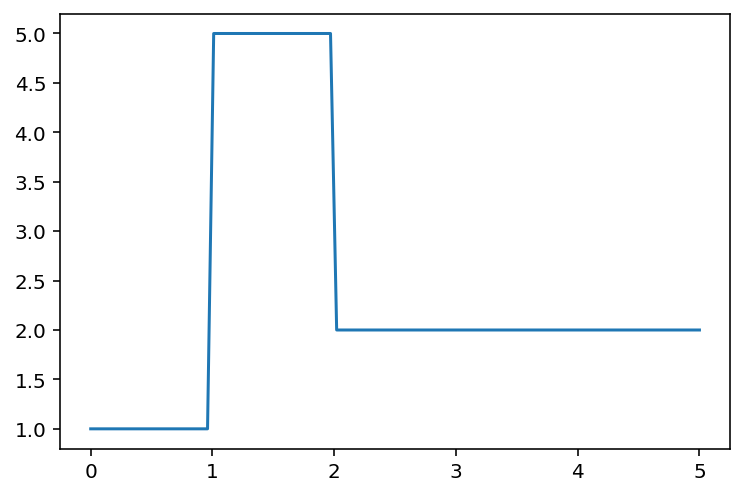

In [431]:
switch_times = [0,1,2]
burst_size_values = [1,5,2]
t = np.linspace(0,5,100)
b_ = np.asarray([burst_size_time_dep(t_) for t_ in t])
plt.plot(t,b_)

In [432]:
initcond = [['thermalized'],
            ['poisson',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob,burst_events = nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,simulation_time=5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 257.08it/s]


In [433]:
X = samples[:,:,1:]

In [434]:
X.shape

(5000, 50, 2)

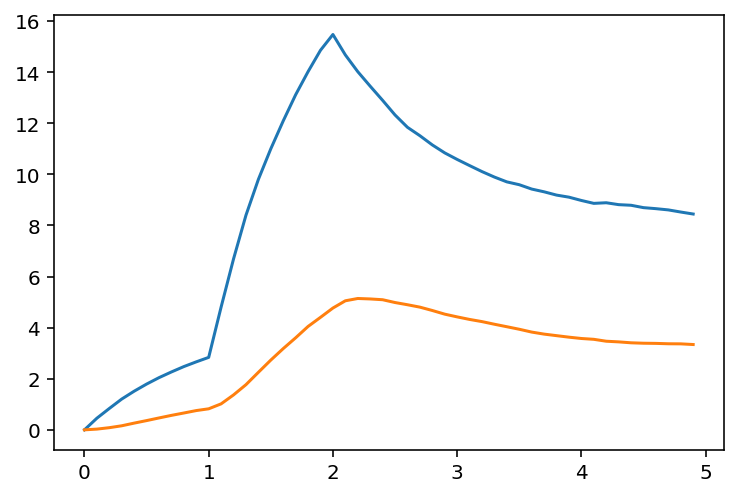

In [435]:
plt.plot(t_arr,X.mean(0))
# plt.plot(t_arr,X.var(0))

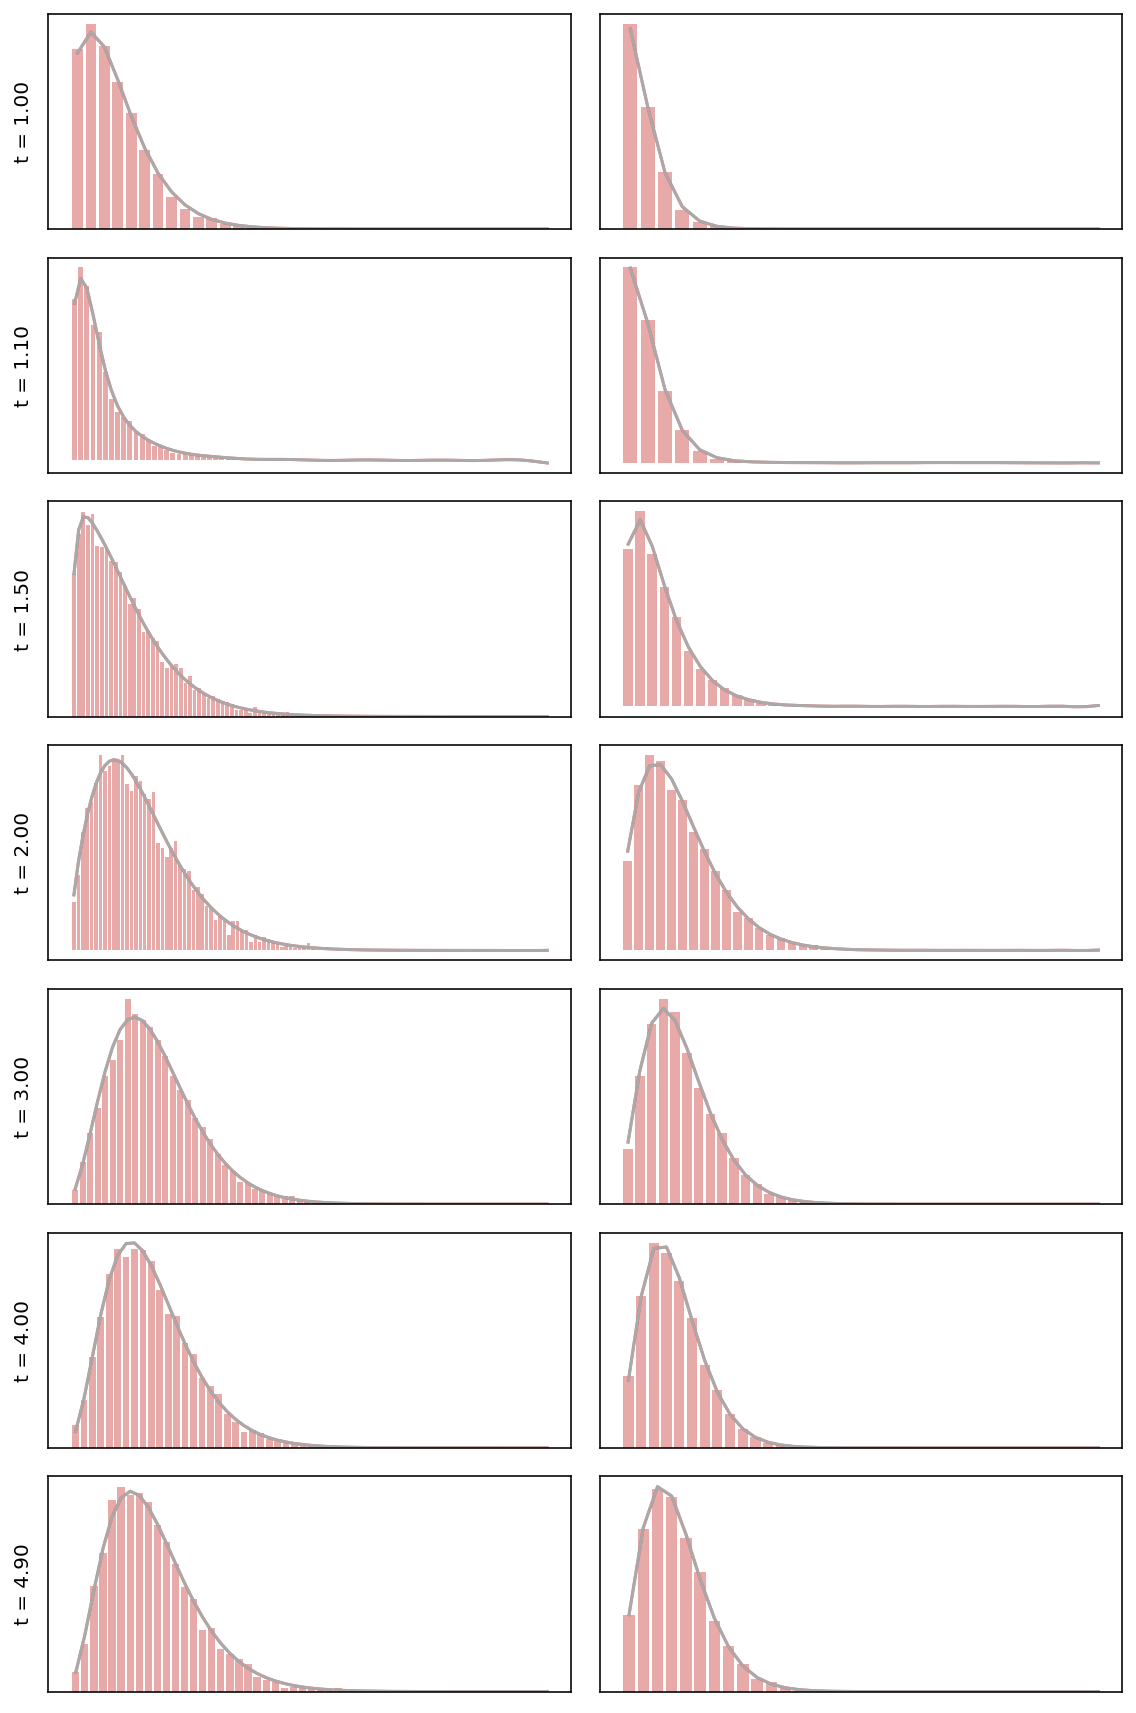

In [436]:
viz_nondelay(t_arr,samples,N,n,H,A,C,burst_size_time_dep,initcond,init_state_prob,t_pts = [10,11,15,20,30,40,49])


In [392]:
exp_reactor = scipy.stats.expon(0,1)
uni_reactor = scipy.stats.uniform(0,2)
x = np.linspace(0,1,102)[1:-1]
t_exp = exp_reactor.ppf(x)
t_uni = uni_reactor.ppf(x)

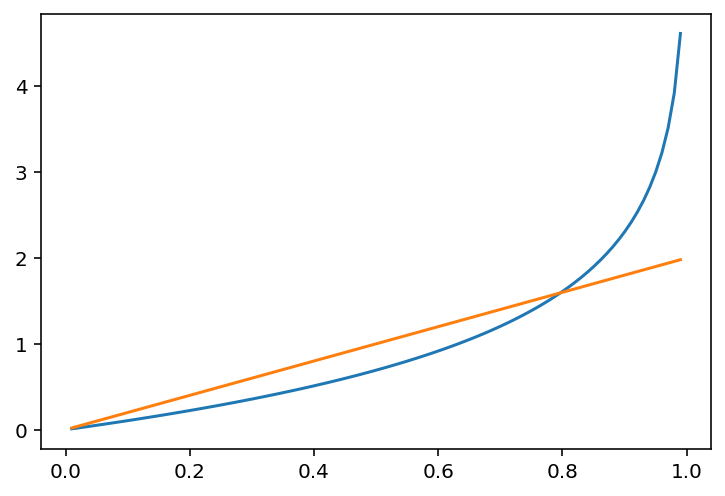

In [393]:
plt.plot(x,t_exp)
plt.plot(x,t_uni)

In [223]:
# t